Importing the Libraries

In [1]:
from PIL import Image,ImageFilter
import torchvision.transforms as transforms
import torch
import matplotlib.pyplot as plt
import os
import numpy as np
import matplotlib.pyplot as plt


Mounting the Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


Installing the **CLIP(Contrastive Language-Image Pretraining)** model from **OpenAI** Github repository


In [3]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 1.7 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-8oxgh3qd
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-8oxgh3qd
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369497 sha256=aa5801a6a61404b1d280d23f1bc3b50acf05608a20017fd0dd67ebc475490b54
  Stored in directory: /tmp/pip-ephem-wheel-cache-xuar8vll/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


In [4]:
import torch
from pkg_resources import packaging
import clip


CLIP Available Model

In [5]:
print("Torch version:", torch.__version__)

clip.available_models()

Torch version: 2.1.0+cu121


['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

Importing "**ViT-L/14**" Model

In [6]:
model, preprocess = clip.load("ViT-L/14")
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

100%|███████████████████████████████████████| 890M/890M [00:11<00:00, 83.8MiB/s]


Model parameters: 427,616,513
Input resolution: 224
Context length: 77
Vocab size: 49408


Applying **Gaussian Blur** and **JPEG Compression**

In [7]:
def custom_augmentation(image_path, blur_prob=0.5, jpeg_prob=1):
    image = Image.open(image_path)

    if torch.rand(1).item() < blur_prob:
        image = image.filter(ImageFilter.GaussianBlur(radius=2))

    if torch.rand(1).item() < jpeg_prob:
        temp_path = 'temp.jpg'
        image.save(temp_path, format='JPEG', quality=80)
        image = Image.open(temp_path)
        os.remove(temp_path)
    return image


  Creating Training Dataset

In [8]:
gan="/content/drive/MyDrive/Deep Fake/Dataset/GAN/biggan"
real="/content/drive/MyDrive/Deep Fake/Dataset/Real/0_real"
train_fake=os.listdir(gan)
train_real=os.listdir(real)

In [9]:
for i in range(len(train_fake)):
   train_fake[i]=gan+'/'+train_fake[i]

for i in range(len(train_real)):
   train_real[i]=real+'/'+train_real[i]

In [10]:
Im_train_fake = []
Im_train_real = []

for i in range(700):
  augumented_img=custom_augmentation(train_fake[i])
  Im_train_fake.append(preprocess(augumented_img))

for i in range(700):
  augumented_img=custom_augmentation(train_real[i])
  Im_train_real.append(preprocess(augumented_img))

In [11]:
image_input_fake = torch.tensor(np.stack(Im_train_fake)).cuda()
image_input_real = torch.tensor(np.stack(Im_train_real)).cuda()

In [12]:
with torch.no_grad():
    features_fake = model.encode_image(image_input_fake).float().cuda()
    features_real = model.encode_image(image_input_real).float().cuda()

In [13]:
print(len(features_fake[0]))

768


In [14]:
labels_fake = torch.zeros(features_fake.shape[0], 1).cuda()
labels_real = torch.ones(features_real.shape[0], 1).cuda()

features = torch.cat([features_fake, features_real])
labels = torch.cat([labels_fake, labels_real])

Defing the parameeters of **Autoencoders**

In [15]:
input_size = features_fake.shape[1]
encoded_size = 200
features = features.cuda()
labels=labels.cuda()

In [16]:
import torch.optim as optim
import torch.nn as nn

Training the **Encoder** and **Decoder**

In [17]:
encoderfn = nn.Sequential(
        nn.Linear(input_size, 1000),
        nn.ReLU(),
        nn.Linear(1000, encoded_size),
        nn.ReLU()
    )
decoderfn = nn.Sequential(
        nn.Linear(encoded_size, 1000),
        nn.ReLU(),
        nn.Linear(1000, input_size),
        nn.Sigmoid()
    )

criterion = nn.MSELoss()
optimizer = optim.Adam(list(encoderfn.parameters()) + list(decoderfn.parameters()), lr=0.001)
encoderfn = encoderfn.cuda()
decoderfn = decoderfn.cuda()
num_epochs = 20
for epoch in range(num_epochs):
        optimizer.zero_grad()
        encoded = encoderfn(features.cuda())
        decoded = decoderfn(encoded)
        loss = criterion(decoded, features)
        loss.backward()
        optimizer.step()
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")


Epoch 1/20, Loss: 0.6942101716995239
Epoch 2/20, Loss: 0.6712843179702759
Epoch 3/20, Loss: 0.6176734566688538
Epoch 4/20, Loss: 0.5222785472869873
Epoch 5/20, Loss: 0.4317368268966675
Epoch 6/20, Loss: 0.40486952662467957
Epoch 7/20, Loss: 0.4032512605190277
Epoch 8/20, Loss: 0.40283918380737305
Epoch 9/20, Loss: 0.40262067317962646
Epoch 10/20, Loss: 0.40362751483917236
Epoch 11/20, Loss: 0.4039897620677948
Epoch 12/20, Loss: 0.4028211236000061
Epoch 13/20, Loss: 0.40347614884376526
Epoch 14/20, Loss: 0.4035838842391968
Epoch 15/20, Loss: 0.40366843342781067
Epoch 16/20, Loss: 0.40472304821014404
Epoch 17/20, Loss: 0.40407612919807434
Epoch 18/20, Loss: 0.4041656255722046
Epoch 19/20, Loss: 0.40374618768692017
Epoch 20/20, Loss: 0.40372326970100403


Reducing the dimension of training data

In [18]:
with torch.no_grad():
      reduced_features = encoderfn(features).float().cuda()
reduced_features_np=reduced_features.cpu().numpy()

In [19]:
labels =labels.cpu().numpy()

Visualizing the Real and Fake Images using **TSNE**

In [20]:
from sklearn.manifold import TSNE

In [21]:
tsne=TSNE(learning_rate=500,n_components=2)
data_norm=reduced_features_np
x_tsne=tsne.fit_transform(data_norm)
y_tsne=labels


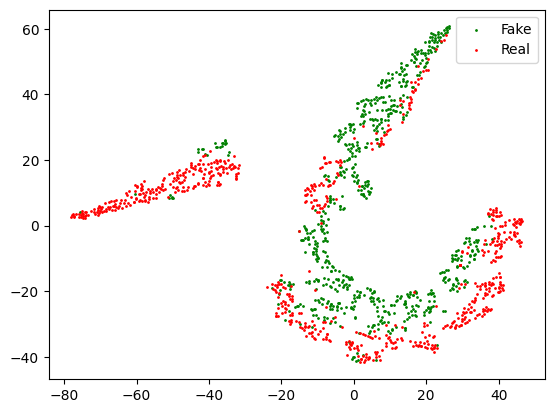

In [22]:
plt.scatter(x_tsne[np.where(y_tsne==0),0],x_tsne[np.where(y_tsne==0),1],color='g',s=1,label="Fake")
plt.scatter(x_tsne[np.where(y_tsne==1),0],x_tsne[np.where(y_tsne==1),1],color='r',s=1,label="Real")
plt.legend()
plt.show()

Creating Test Dataset

In [23]:
dalle="/content/drive/MyDrive/Deep Fake/Dataset/DM/Dalle/1_fake"
real="/content/drive/MyDrive/Deep Fake/Dataset/Real/0_real"
test_fake=os.listdir(dalle)
test_real=os.listdir(real)

In [24]:
for i in range(len(test_fake)):
   test_fake[i]=dalle+'/'+test_fake[i]

for i in range(len(test_real)):
   test_real[i]=real+'/'+test_real[i]

In [25]:
test=[]

for i in range(100,400):
  test.append([test_fake[i],0])

for i in range(700,1000):
  test.append([test_real[i],1])

**Nearest Neighbours** (Classification)

In [26]:
from sklearn.neighbors import NearestNeighbors
nn_model = NearestNeighbors(n_neighbors=5, metric='cosine')
nn_model.fit(reduced_features_np)

NearestNeighbors(metric='cosine')

In [27]:
def predict_real_or_fake_nn(image_input, threshold=0.5):
    features = model.encode_image(image_input).float().cuda()
    with torch.no_grad():
      reduced_features = encoderfn(features).float().cuda()
    features=reduced_features.cpu().numpy()

    _, indices = nn_model.kneighbors(features, 5)

    nearest_neighbor_labels = labels[indices[0]]

    prediction = 1 if sum(nearest_neighbor_labels) >= 3 else 0

    return prediction


In [28]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_model_nn(test_data):
    predictions = []
    ground_truth = []

    with torch.no_grad():
        for image_path, label in test_data:
            img=custom_augmentation(image_path)
            image = preprocess(img).unsqueeze(0).cuda()
            prediction = predict_real_or_fake_nn(image)
            predictions.append(prediction)
            ground_truth.append(label)
            # print("prediction",prediction,"  true",label)

    predictions = torch.tensor(predictions).cuda()
    ground_truth = torch.tensor(ground_truth).cuda()

    accuracy = accuracy_score(ground_truth.cpu(), predictions.cpu())
    precision = precision_score(ground_truth.cpu(), predictions.cpu())
    recall = recall_score(ground_truth.cpu(), predictions.cpu())
    f1 = f1_score(ground_truth.cpu(), predictions.cpu())

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")


Evaluation of Nearest Neighbour model

In [29]:
evaluate_model_nn(test)

Accuracy: 0.8283
Precision: 0.8031
Recall: 0.8700
F1 Score: 0.8352


**Decision Tree Classifier** (Classification)

In [30]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(max_depth=9)


In [31]:
dtc.fit(reduced_features_np,labels)

DecisionTreeClassifier(max_depth=9)

In [32]:
def predict_real_or_fake_dt(image_input, decision_tree_model):
  features = model.encode_image(image_input).float().cuda()
  with torch.no_grad():
      reduced_features = encoderfn(features).float().cuda()
  features=reduced_features.cpu().numpy()
  return decision_tree_model.predict(features)

In [33]:
def evaluate_model_dt(test_data):
    predictions = []
    ground_truth = []

    with torch.no_grad():
        for image_path, label in test_data:
            img=custom_augmentation(image_path)
            image = preprocess(img).unsqueeze(0).cuda()
            prediction = predict_real_or_fake_dt(image,dtc)
            predictions.append(prediction)
            ground_truth.append(label)

    predictions = torch.tensor(predictions).cuda()
    ground_truth = torch.tensor(ground_truth).cuda()

    accuracy = accuracy_score(ground_truth.cpu(), predictions.cpu())
    precision = precision_score(ground_truth.cpu(), predictions.cpu())
    recall = recall_score(ground_truth.cpu(), predictions.cpu())
    f1 = f1_score(ground_truth.cpu(), predictions.cpu())

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

Evaluation of Decision Tree

In [34]:
evaluate_model_dt(test)

Accuracy: 0.7250
Precision: 0.6945
Recall: 0.8033
F1 Score: 0.7450


<ipython-input-33-c5fddf11d9b1>:13: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  predictions = torch.tensor(predictions).cuda()


**Support Vector Classification**

In [35]:
from sklearn import svm
model_svm = svm.SVC(kernel='rbf')

In [36]:
model_svm.fit(reduced_features_np,labels)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC()

In [37]:
def predict_real_or_fake_svm(image_input, svm):
  features = model.encode_image(image_input).float().cuda()
  with torch.no_grad():
      reduced_features = encoderfn(features).float().cuda()
  features=reduced_features.cpu().numpy()
  return svm.predict(features)

In [38]:
def evaluate_model_svm(test_data):
    predictions = []
    ground_truth = []

    with torch.no_grad():
        for image_path, label in test_data:
            img=custom_augmentation(image_path)
            image = preprocess(img).unsqueeze(0).cuda()
            prediction = predict_real_or_fake_dt(image,model_svm)
            predictions.append(prediction)
            ground_truth.append(label)

    predictions = torch.tensor(predictions).cuda()
    ground_truth = torch.tensor(ground_truth).cuda()

    accuracy = accuracy_score(ground_truth.cpu(), predictions.cpu())
    precision = precision_score(ground_truth.cpu(), predictions.cpu())
    recall = recall_score(ground_truth.cpu(), predictions.cpu())
    f1 = f1_score(ground_truth.cpu(), predictions.cpu())

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

Evaluation of Support Vector

In [39]:
evaluate_model_svm(test)

Accuracy: 0.7150
Precision: 0.6748
Recall: 0.8300
F1 Score: 0.7444
